<a href="https://colab.research.google.com/github/kmuhan/kmuhandeeplearning/blob/main/longevity_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2학년 1학기 때 했던 선형 회귀 도출 프로젝트를 회귀 신경망 딥러닝으로 재구성 하고자 하였음

전체 학습 data n = 4041 [weight, longevity] (150, 2)로 이루어져 있음

입력층 뉴런: n = 1

은닉층 뉴런: n = 25

출력층 뉴런: n = 1

은닉층 활성화 함수: Leaky ReLU

출력층 함수: 항등함수

E: MSE

최적화 알고리즘: ADAGRAD + DROPOUT

batch size: 40

epoch: 1000


In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

animal_data = []

file_path = "/content/data_all.txt"
with open(file_path, 'r') as file:
  for line in file:
    p = line.strip('/n')
    animal_data.append([float(eval(p)['weight']), float(eval(p)['longevity'])])

animal_data = np.array(animal_data) # 데이터 개수는 4041개
train_data = animal_data[:3000]
test_data = animal_data[3000:]

#train data와 test data를 구분하고, 소수 첫째 자리까지 반올림
input_train = np.round_(train_data[:, 0], 1)
correct_train = np.round(train_data[:, 1], 1)
input_test = np.round(test_data[:, 0], 1)
correct_test = np.round(test_data[:, 1], 1)

n_train = len(input_train)
n_test = len(input_test)

n_in = 1
n_mid = 25
n_out = 1

wb_width = 0.05 
eta = 0.01
epoch = 1000
batch_size = 40
interval = 50

In [ ]:
class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

    self.h_w = np.zeros((n_upper, n)) + 1e-8
    self.h_b = np.zeros(n) + 1e-8

  def update(self, eta):
    self.h_w += self.grad_w * self.grad_w
    self.w -= (eta / np.sqrt(self.h_w)) * self.grad_w

    self.h_b += self.grad_b * self.grad_b
    self.b -= (eta / np.sqrt(self.h_b)) * self.grad_b


In [ ]:
class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = u
  
  def backward(self, t):
    delta = self.y - t

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

In [ ]:
class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0.001*self.u, self.u)

  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0.001, 1)

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

In [ ]:
class Dropout:
  def __init__(self, dropout_ratio):
    self.dropout_ratio = dropout_ratio
  
  def forward(self, x, is_train):
    if is_train:
      rand = np.random.rand(*x.shape)
      self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
      self.y = x * self.dropout_ratio
    else:
      self.y = (1 - self.dropout_ratio) * x
    
  def backward(self, grad_y):
    self.grad_x = grad_y * self.dropout

In [ ]:
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
middle_layer_3 = MiddleLayer(n_mid, n_mid)
dropout_3 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

In [ ]:
def forward_propagation(x, is_train):
  middle_layer_1.forward(x)
  dropout_1.forward(middle_layer_1.y, is_train)
  middle_layer_2.forward(dropout_1.y)
  dropout_2.forward(middle_layer_2.y, is_train)
  middle_layer_3.forward(dropout_2.y)
  dropout_3.forward(middle_layer_3.y, is_train)
  output_layer.forward(dropout_3.y)

def backward_propagation(t):
  output_layer.backward(t)
  dropout_3.backward(output_layer.grad_x)
  middle_layer_3.backward(dropout_3.grad_x)
  dropout_2.backward(output_layer.grad_x)
  middle_layer_2.backward(dropout_2.grad_x)
  dropout_1.backward(middle_layer_2.grad_x)
  middle_layer_1.backward(dropout_1.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  middle_layer_3.update(eta)
  output_layer.update(eta)

def get_error(y, t):
  return 1.0/2.0*np.sum(np.square(y - t))

In [ ]:
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [ ]:
n_batch = n_train // batch_size
for i in range(epoch):
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)
  y_total = 0
  t_total = 0

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index]
    t = correct_train[mb_index]
    
    x = np.array(x)
    t = np.array(t)

    x = np.reshape(x, (40, 1))
    t = np.reshape(t, (40, 1))

    forward_propagation(x, True)
    backward_propagation(t)

    update_wb()

    y_total += np.sum(output_layer.y)
    t_total += np.sum(t)
  
  forward_propagation(x, True)
  error_train = get_error(y_total, t_total)
  forward_propagation(np.reshape(input_test, (len(input_test), 1)), False)
  error_test = get_error(np.sum(input_test), np.sum(correct_test))

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train : " + str(error_train),
          "Error_test: " + str(error_test))

Epoch: 0/1000 Error_train : 1104210221.8362484 Error_test: 15880043612.480001
Epoch: 50/1000 Error_train : 920023904.0933082 Error_test: 15880043612.480001
Epoch: 100/1000 Error_train : 644780394.0658317 Error_test: 15880043612.480001
Epoch: 150/1000 Error_train : 365800267.3814876 Error_test: 15880043612.480001
Epoch: 200/1000 Error_train : 142295460.51634055 Error_test: 15880043612.480001
Epoch: 250/1000 Error_train : 32040506.734212857 Error_test: 15880043612.480001
Epoch: 300/1000 Error_train : 6491238.098869587 Error_test: 15880043612.480001
Epoch: 350/1000 Error_train : 2298126.988539763 Error_test: 15880043612.480001
Epoch: 400/1000 Error_train : 1037974.4010148597 Error_test: 15880043612.480001
Epoch: 450/1000 Error_train : 1546976.9397683125 Error_test: 15880043612.480001
Epoch: 500/1000 Error_train : 1732835.6191028184 Error_test: 15880043612.480001
Epoch: 550/1000 Error_train : 1306993.2153618746 Error_test: 15880043612.480001
Epoch: 600/1000 Error_train : 1260169.7203588828

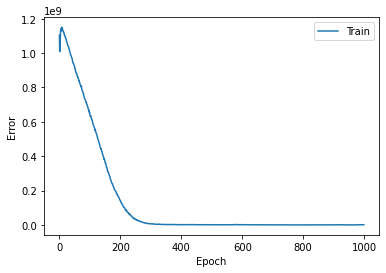

longevity : [[53.82104454]]


In [ ]:

plt.plot(train_error_x, train_error_y, label="Train")
# plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")

plt.show()

forward_propagation([[10000]], True)
print("longevity : " + str(output_layer.y))